In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.display import Image

# Structure d'un script/notebook simple avec Keras

-------------------------------
-------------------------------
- Charger les données
- Traiter les données (augmentation ? réduction ?)
- Gérer les labels (one-hot encoding)
- Découpage train/test
-------------------------------
-------------------------------
- Construire le modèle 
- Choisir la fonction de coût, des métriques, un algorithme d'optimisation 
- Compiler le modèle 
- Configurer l'entrainement (`batch_size`, `nb_epoch`, ...)
- Lancer l'entraînement 
-------------------------------
-------------------------------
- Lancer l'inférence sur les nouvelles données à labeliser 
- [Générer le fichier .csv de résultats à envoyer sur Kaggle] 
-------------------------------
-------------------------------

# Les données : Digit-Recognizer de Kaggle 

Reconnaissance de caractères manuscrits (0 à 9)

- Application aux chèques bancaires 
- Yann LeCun a créé le modèle LeNet-5 dans les années 90 sur ce type de problème ! 
- Benchmark en Deep Learning

Données déjà préparées : 
- découpage train/test 
- normalisation des données (preprocessing) 

Reste à faire : `one-hot encoding`

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [6]:
X_train = np.load('../data/digit-recognizer/X_train.npy')
X_test = np.load('../data/digit-recognizer/X_test.npy')

y_train = np.load('../data/digit-recognizer/y_train.npy')
y_test = np.load('../data/digit-recognizer/y_test.npy')

In [7]:
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (33600, 784)
X_test shape : (8400, 784)
y_train shape : (33600,)
y_test shape : (8400,)


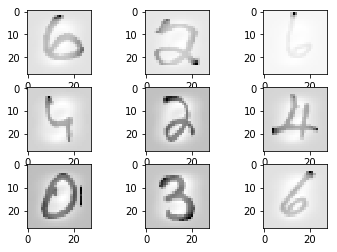

[6 2 6 4 2 4 0 3 6]


In [8]:
# Afficher quelques exemples 
for i in range(9):
    plt.subplot(331+i)
    #Les images sont sous forme de vecteurs, de taille 784=28x28
    plt.imshow(X_train[i].reshape(28,28), cmap=cm.binary)
plt.show()
print(y_train[:9])

 # Prendre en main Keras : régression logistique 

2 API pour construire un modèle avec Keras 
- **Sequential**
    - Empiler les couches, 1 entrée et 1 sortie 
- **Functional**
    - Plusieurs entrées et sorties ! 
 
Ce soir : `Sequential` uniquement !  
 
    
### Première étape :  construire le modèle

Caisse à outils : 

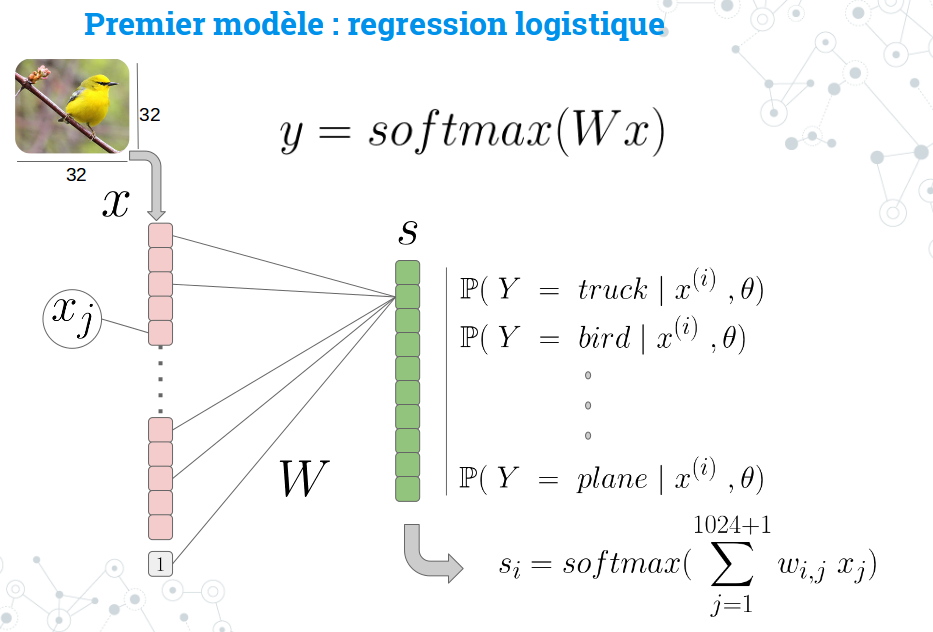

In [9]:
Image(filename='../ressources/regression_logistique.png')

- modèle non profond (aucune couche cachée)

In [10]:
#On charge l'API voulue
from keras.models import Sequential

#et les couches nécessaires 
from keras.layers import Dense, Activation

from keras.regularizers import l2

Using TensorFlow backend.


## La couche `Dense`

Couche 'full-connected' classique 

```python
keras.layers.core.Dense(output_dim, 
                        init='glorot_uniform',
                        activation=None,
                        weights=None,
                        W_regularizer=None,
                        b_regularizer=None,
                        activity_regularizer=None,
                        W_constraint=None,
                        b_constraint=None,
                        bias=True,
                        input_dim=None)
```

- **output_dim**: int > 0.
- **init**: nom de la règle d'initialisation des poids. (uniform, normal, identity, orthogonal, zero, one, glorot_normal, glorot_uniform, he_normal, he_uniform, ...)
- **activation**: nom de la fonction d'activation (pour l'instant `softmax`)
- **W_regularizer**: instance d'un `WeightRegularizer` (eg. L1 or L2 regularization), appliqué aux poids de la matrice.
- **b_regularizer**: instance d'un `WeightRegularizer`, appliqué au vecteur de biais.
- **input_dim**: dimension du vecteur d'entrée, à spécifier uniquement pour la première couche. 

-------------------------------------------------------

Comment ajouter la régularisation L2 ? 


```python 
from keras.regularizers import l2
model.add(Dense(64, input_dim=64, W_regularizer=l2(0.01)))
```


(ici uniquement sur la matrice W)

In [12]:
# On peut ensuite construire le modèle 
# En ajoutant les couches dans 'model'
model = Sequential()

# Dans la première couche, il faut toujours spécifier la dimension d'entrée ! Ici un vecteur de taille 784
model.add(Dense(10, input_dim=784, W_regularizer=l2(0.01)))
model.add(Activation('softmax'))

In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_2 (Dense)                  (None, 10)            7850        dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 10)            0           dense_2[0][0]                    
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
____________________________________________________________________________________________________


### Seconde étape : fonction de coût ? métriques ? algorithme d'optimisation ?

Métriques :
    - uniquement indicatives 
    - calculées sur chaque batch et pour les données de test (ou validation_data dans Keras)

Fonction de coût :
    - fonction à minimiser 
    - Cas de la classification multi-classes  : `categorical_crossentropy`


Pour aller plus loin: écrire ses propres métriques !

In [15]:
# Il existe beaucoup de méthodes d'optimisation : ce soir uniquement SGD 
from keras.optimizers import SGD

In [16]:
# choix du `learning rate` (il existe d'autres paramètres pour SGD)
sgd = SGD(lr=0.0001)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Troisième étape : entraînement

On indique : 
- les données d'entraînement (X_train,y_train)
- la taille des batch 
- le nombre d'epoch
- les données de test (ou validation) 

```python
model.fit(X_train, y_train,
          batch_size=32, nb_epoch=10, verbose=1,
          validation_split=0.0, validation_data=None,
          shuffle=True,
          class_weight=None, sample_weight=None,
          initial_epoch=0,
          callbacks=None)
```



In [17]:
# one-hot encoding à ne pas oublier !
from keras.utils.np_utils import to_categorical

In [18]:
batch_size = 32
nb_epoch = 30

history = model.fit(X_train, to_categorical(y_train,nb_classes=10),
                    batch_size = batch_size,
                    nb_epoch = nb_epoch,
                    verbose=0,
                    validation_data=(X_test, to_categorical(y_test,nb_classes=10)))


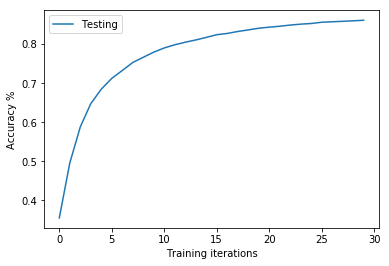

In [19]:
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

## Appliquer le modèle à de nouvelles données 

**3 façon de lancer l'inférence :** 

```python
# Calcule l'erreur et les métriques 
model.evaluate(self, x, y, batch_size=32, verbose=1)

# Renvoie pour chaque exemple un vecteur de probabilité 
model.predict(self, x, batch_size=32, verbose=0)

# Renvoie pour chaque exemple la classe prédite 
model.predict_classes(self, x, batch_size=32, verbose=0)
```

In [20]:
test_data = np.load('../data/digit-recognizer/test_data.npy')
print(test_data.shape)

(28000, 784)


In [21]:
predictions = model.predict_classes(test_data,batch_size=128,verbose=1)

28000/28000 [==============================] - 0s     

In [22]:
predictions

array([2, 0, 9, ..., 3, 9, 2])

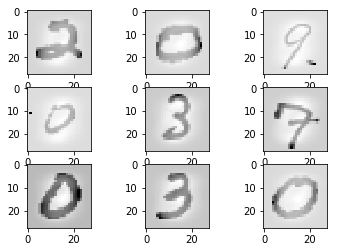

[2 0 9 7 2 7 0 3 0]


In [23]:
# Afficher quelques exemples 
for i in range(9):
    plt.subplot(331+i)
    #Les images sont sous forme de vecteurs, de taille 784=28x28
    plt.imshow(test_data[i].reshape(28,28), cmap=cm.binary)
plt.show()
print(predictions[:9])

In [21]:
# A faire chez soi : envoyerrésultats sur Kaggle
import pandas as pd

pd.DataFrame({"ImageId": list(range(1,len(test_data)+1)), 
              "Label": predictions}).to_csv('DIGIT-RECOGNIZER-submission.csv', index=False,header=True)

# Enregistrer son modèle

#### Uniquement l'architecture du modèle dans un fichier json

In [22]:
import json

json_string = model.to_json()

with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [23]:
cat model.json

"{\"config\": [{\"config\": {\"input_dim\": 784, \"bias\": true, \"b_regularizer\": null, \"output_dim\": 10, \"W_regularizer\": {\"name\": \"L1L2Regularizer\", \"l1\": 0.0, \"l2\": 0.009999999776482582}, \"b_constraint\": null, \"name\": \"dense_1\", \"activity_regularizer\": null, \"activation\": \"linear\", \"W_constraint\": null, \"init\": \"glorot_uniform\", \"batch_input_shape\": [null, 784], \"input_dtype\": \"float32\", \"trainable\": true}, \"class_name\": \"Dense\"}, {\"config\": {\"name\": \"activation_1\", \"activation\": \"softmax\", \"trainable\": true}, \"class_name\": \"Activation\"}], \"keras_version\": \"1.2.1\", \"class_name\": \"Sequential\"}"

In [24]:
# Pour instacier un modèle depuis un fichier JSON : 
from keras.models import model_from_json

with open("model.json") as json_file:
    json_string = json.load(json_file)

model2 = model_from_json(json_string)
#Le modèle model2 a la même architecture, mais des poids différents (poids initiaux aléatoires)

#### Uniquement les poids entraînés dans un fichier hdf5

In [25]:
model.save_weights('weights.h5')

In [26]:
model2.load_weights('weights.h5')

#### Achitecture + poids entraînés dans un fichier hdf5

In [27]:
model.save('model_weights.h5')

In [29]:
from keras.models import load_model
model3 = load_model('model_weights.h5')